In [55]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
(X_train,_),(X_test,_) = mnist.load_data()

In [23]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


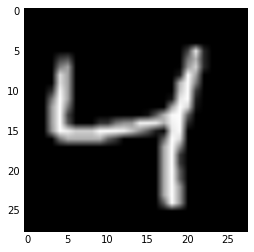

In [59]:
plt.imshow(X_train[2].reshape(28,28), cmap='gray')

# Reshape the data to have 1 channel

In [24]:
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))

In [25]:

print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# Create the autoencoder

In [14]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train it

In [27]:
autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, callbacks=None )

Epoch 1/2
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0033
Epoch 2/2
60000/60000 [==============================] - 86s 1ms/step - loss: 1.7230e-06


In [28]:
autoencoder.save('autoencoder.h5')

In [29]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0         
__________

# Create the encoder part
The encoder part is the first half of the autoencoder, i.e. the part that will encode the input into a latent space representation. In this case, the dimension of this representation is $4 \times 4 \times 8$

In [30]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [31]:
encoder.save('encoder.h5')

# Load the query image¶
We take a query image from the test set

In [32]:
query = X_test[7]

In [61]:
query.shape

(28, 28, 1)

In [62]:
query

array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]

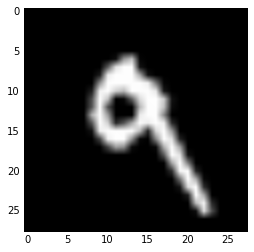

In [33]:
plt.imshow(query.reshape(28,28), cmap='gray')

# Encode the test images and the query image

In [34]:
X_test.shape

(10000, 28, 28, 1)

We remove the query image from the test set (the set in which we will search for close images)

In [35]:
X_test = np.delete(X_test, 7, axis=0)

In [36]:
X_test.shape

(9999, 28, 28, 1)

# Encode the query image and the test set

In [38]:
codes = encoder.predict(X_test)

In [40]:
query_code = encoder.predict(query.reshape(1,28,28,1))

In [41]:
codes.shape,query_code.shape

((9999, 4, 4, 8), (1, 4, 4, 8))

In [63]:
query_code.shape

(1, 128)

In [60]:
query_code

array([[0.5198475 , 0.08896601, 0.9492    , 1.0404446 , 0.99167734,
        0.5058188 , 0.        , 1.5764164 , 0.5106403 , 0.08991284,
        0.93966514, 1.0433472 , 0.9966842 , 0.5026657 , 0.        ,
        1.5728695 , 0.5098872 , 0.09022792, 0.9359039 , 1.0392988 ,
        0.9938914 , 0.5012397 , 0.        , 1.561357  , 0.3452297 ,
        0.11129037, 0.6750804 , 0.6340816 , 0.6434199 , 0.34784275,
        0.06338744, 0.9475989 , 0.46744636, 0.        , 0.94489604,
        1.0466547 , 0.9931808 , 0.43953073, 0.        , 1.5717359 ,
        0.45733216, 0.        , 0.94123214, 1.0494044 , 1.0015339 ,
        0.41491818, 0.        , 1.57471   , 0.455988  , 0.        ,
        0.9374564 , 1.0435294 , 0.9954705 , 0.41062987, 0.        ,
        1.5649655 , 0.23031415, 0.        , 0.67398   , 0.6347029 ,
        0.6433506 , 0.19897181, 0.03254183, 0.9431616 , 0.46588948,
        0.        , 0.941392  , 1.0440037 , 0.99178404, 0.43889606,
        0.        , 1.5644182 , 0.4539101 , 0.  

# Find the closest images

In [43]:
from sklearn.neighbors import NearestNeighbors

We will find the 5 closest images

In [44]:
n_neigh = 5

In [45]:
codes = codes.reshape(-1, 4*4*8); print(codes.shape)
query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)

(9999, 128)
(1, 128)


# Fit the KNN to the test set

In [47]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

In [48]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [49]:
closest_images = X_test[indices]

In [50]:
closest_images = closest_images.reshape(-1,28,28,1); print(closest_images.shape)

(5, 28, 28, 1)


# Get the closest images

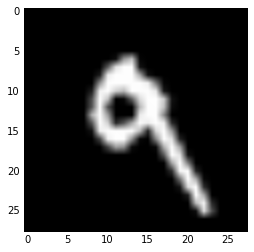

In [51]:
plt.imshow(query.reshape(28,28), cmap='gray')

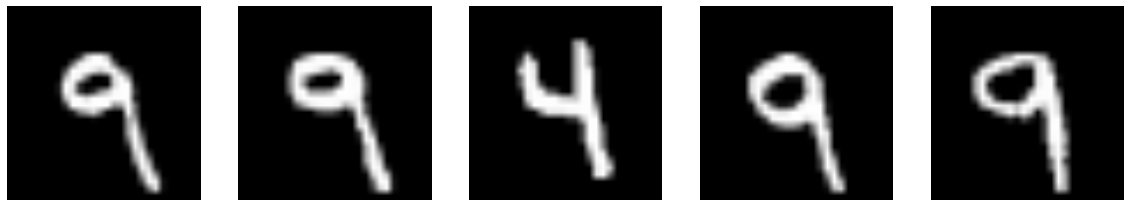

In [52]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()